# 0. Preprocessing Experiment

**Objective:** Test the video preprocessing pipeline on a small, random sample of videos before running it on the entire dataset.

This notebook will:
1.  Select a few random videos from the 'real' and 'fake' directories.
2.  Adapt the face extraction logic from `scripts/preprocess_videos.py`.
3.  Process the sample videos, extracting and cropping faces.
4.  Visualize the extracted faces directly in the notebook for immediate quality control.

In [1]:
import os
import cv2
from PIL import Image
import torch
from facenet_pytorch import MTCNN
import matplotlib.pyplot as plt
import random
import numpy as np

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu126
CUDA available: True


## 1. Configuration

We'll set up the same configuration as the main script: paths, device, face detector, and processing parameters.

In [2]:
# --- Configuration ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

# Define project paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
FAKE_DIR = os.path.join(DATA_DIR, "fake")
REAL_DIR = os.path.join(DATA_DIR, "real")

# For this experiment, we won't save files, just visualize.

# Sampling & face settings
FRAME_SKIP = 15               # Sample 1 frame every 15 frames for faster experimentation
IMAGE_SIZE = (224, 224)
CONFIDENCE_THRESHOLD = 0.90   # Filter weak detections

## 2. Core Processing Function

This function is adapted from `preprocess_videos.py`. Instead of saving the faces to disk, it will return a list of PIL Image objects for us to display.

In [3]:
def extract_faces_from_video(video_path):
    """Extracts face images from a single video file and returns them as a list of PIL Images."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open {video_path}")
        return []

    extracted_faces = []
    frame_idx = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % FRAME_SKIP == 0:
            # Convert frame to PIL Image
            img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img_pil = Image.fromarray(img_rgb)

            # Detect faces
            boxes, probs = mtcnn.detect(img_pil)
            
            if boxes is not None:
                for i, box in enumerate(boxes):
                    if probs[i] > CONFIDENCE_THRESHOLD:
                        # Crop face
                        x1, y1, x2, y2 = [int(b) for b in box]
                        face = img_pil.crop((x1, y1, x2, y2))
                        face = face.resize(IMAGE_SIZE)
                        extracted_faces.append(face)
        
        frame_idx += 1

    cap.release()
    return extracted_faces

## 3. Select Sample Videos

Let's grab 2 real and 2 fake videos to test our function.

In [4]:
try:
    fake_video_files = [f for f in os.listdir(FAKE_DIR) if f.endswith('.mp4')]
    real_video_files = [f for f in os.listdir(REAL_DIR) if f.endswith('.mp4')]

    # Select random samples
    sample_fake_videos = random.sample(fake_video_files, 2)
    sample_real_videos = random.sample(real_video_files, 2)

    print("Selected Fake Videos:", sample_fake_videos)
    print("Selected Real Videos:", sample_real_videos)
except ValueError as e:
    print(f"Error: Could not sample videos. Make sure the directories are not empty. Details: {e}")
except FileNotFoundError as e:
    print(f"Error: Data directory not found. Make sure your data is in the correct location. Details: {e}")

Selected Fake Videos: ['230_204.mp4', 'id28_id22_0009.mp4']
Selected Real Videos: ['868.mp4', '336.mp4']


## 4. Run Experiment and Visualize Results

Now we'll loop through our selected videos, run the extraction function, and plot the results.


--- Processing FAKE video: 230_204.mp4 ---
Found 25 faces.


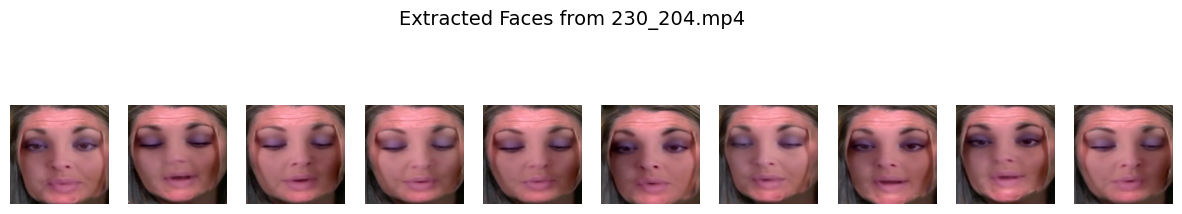


--- Processing FAKE video: id28_id22_0009.mp4 ---
Found 23 faces.


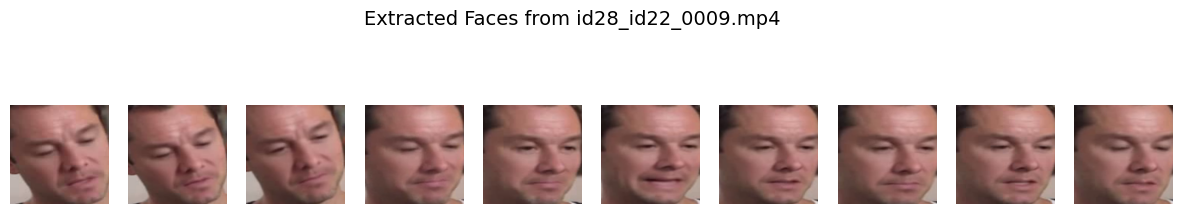


--- Processing REAL video: 868.mp4 ---
Found 29 faces.


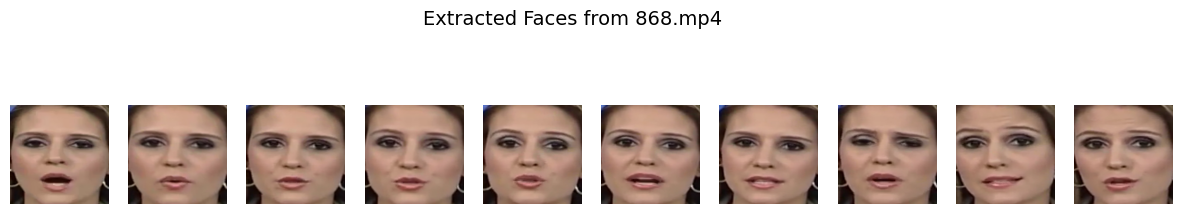


--- Processing REAL video: 336.mp4 ---
Found 34 faces.


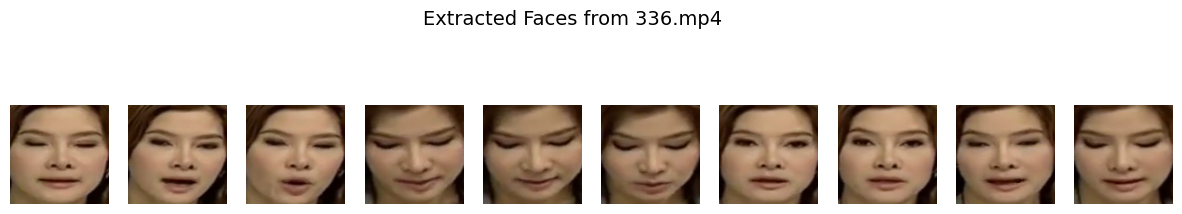

In [5]:
def run_and_visualize(video_list, source_dir, label):
    """Processes a list of videos and plots the extracted faces."""
    for video_file in video_list:
        print(f"\n--- Processing {label} video: {video_file} ---")
        video_path = os.path.join(source_dir, video_file)
        
        faces = extract_faces_from_video(video_path)
        
        if not faces:
            print("No faces found or extracted.")
            continue
            
        print(f"Found {len(faces)} faces.")
        
        # Plot the faces
        plt.figure(figsize=(15, 3))
        plt.suptitle(f'Extracted Faces from {video_file}', fontsize=14)
        for i, face in enumerate(faces[:10]): # Display up to 10 faces
            plt.subplot(1, 10, i + 1)
            plt.imshow(face)
            plt.axis('off')
        plt.show()

# Run for FAKE videos
if 'sample_fake_videos' in locals():
    run_and_visualize(sample_fake_videos, FAKE_DIR, 'FAKE')

# Run for REAL videos
if 'sample_real_videos' in locals():
    run_and_visualize(sample_real_videos, REAL_DIR, 'REAL')

## Conclusion

After running the cells above, we should see the faces extracted from your sample videos. 

**Things to check:**
- Are the faces well-centered and correctly cropped?
- Is the quality of the images reasonable?
- Did the code run without errors?

If everything looks good, we can proceed to run the full `scripts/preprocess_videos.py` script to process all your videos.